In [4]:
import os 
import pandas as pd 
import rasterio 
import numpy as np

In [5]:
path_dataset = '../../dfc25_track2_trainval/'

In [6]:
train_post_files = os.listdir(path_dataset + 'train/post-event/')
train_label_maps = os.listdir(path_dataset + 'train/target/')

**CHECK # SAR bands per train tile**

In [16]:
number_of_sar_bands = [] 
for file in train_post_files:
    with rasterio.open(os.path.join(path_dataset, 'train/post-event/' + file)) as src:
        img = src.read() 
        number_of_sar_bands.append(img.shape[0])

In [17]:
print(f'Unique number of SAR bands in post-event files: {set(number_of_sar_bands)}')

Unique number of SAR bands in post-event files: {1}


**TARGET CLASS DISTRIBUTION PER TRAIN TILE**

In [7]:
target_dist_train = [] 

for file in train_label_maps:
    with rasterio.open(os.path.join(path_dataset, 'train/target/' + file)) as src:
        img = src.read()
        min_lon, min_lat, max_lon, max_lat = src.bounds 

        if min_lon > max_lon: # take intern. date line into account (180/0) 
            max_lon += 360 
        center_lon = (min_lon + max_lon) / 2
        center_lat = (min_lat + max_lat) / 2
        
        if center_lon > 180: # readjust to [-180, 180]
            center_lon -= 360
        
        targets_present = np.unique(img)
        background = np.count_nonzero(img == 0)
        building = np.count_nonzero(img)
        intact = np.count_nonzero(img == 1)
        damaged = np.count_nonzero(img == 2)
        destroyed = np.count_nonzero(img == 3)
        tile_post = file.replace('_building_damage', '_post_disaster')
        tile_pre = file.replace('_building_damage', '_pre_disaster')
        target_dist_train.append({
            'tile_mask': file, 
            'tile_pre': tile_pre,
            'tile_post': tile_post,
            'center_lon': center_lon,
            'center_lat': center_lat,
            'targets': np.array2string(targets_present),
            'background': background,
            'building': building,
            'intact': intact,
            'damaged': damaged,
            'destroyed': destroyed
        })

In [8]:
target_dist_train = pd.DataFrame(target_dist_train)

In [9]:
# pixel per image ratio
target_dist_train['background_ratio'] = target_dist_train['background'] / (1024**2)
target_dist_train['building_ratio'] = target_dist_train['building'] / (1024**2)
target_dist_train['intact_ratio'] = target_dist_train['intact'] / (1024**2)
target_dist_train['damaged_ratio'] = target_dist_train['damaged'] / (1024**2)
target_dist_train['destroyed_ratio'] = target_dist_train['destroyed'] / (1024**2)

# pixel per building ratio 
target_dist_train['intact_building_ratio'] = target_dist_train['intact'] / target_dist_train['building']
target_dist_train['damaged_building_ratio'] = target_dist_train['damaged'] / target_dist_train['building']
target_dist_train['destroyed_building_ratio'] = target_dist_train['destroyed'] / target_dist_train['building']

In [10]:
target_dist_train['place'] = target_dist_train.apply(lambda x: x['tile_post'].split('-')[0], axis=1)
target_dist_train['disaster'] = target_dist_train.apply(lambda x: x['tile_post'].split('-')[1].split('_')[0], axis=1)

In [11]:
target_dist_train.head()

,tile_mask,tile_pre,tile_post,center_lon,center_lat,targets,background,building,intact,damaged,...,background_ratio,building_ratio,intact_ratio,damaged_ratio,destroyed_ratio,intact_building_ratio,damaged_building_ratio,destroyed_building_ratio,place,disaster
0,la_palma-volcano_00000077_building_damage.tif,la_palma-volcano_00000077_pre_disaster.tif,la_palma-volcano_00000077_post_disaster.tif,211955.132484,3.172715e+06,[0 1],1026055,22521,22521,0,...,0.978522,0.021478,0.021478,0.000000,0.000000,1.000000,0.000000,0.000000,la_palma,volcano
1,congo-volcano_00000053_building_damage.tif,congo-volcano_00000053_pre_disaster.tif,congo-volcano_00000053_post_disaster.tif,29.233665,-1.629626e+00,[0 1],1031324,17252,17252,0,...,0.983547,0.016453,0.016453,0.000000,0.000000,1.000000,0.000000,0.000000,congo,volcano
2,turkey-earthquake_00000537_building_damage.tif,turkey-earthquake_00000537_pre_disaster.tif,turkey-earthquake_00000537_post_disaster.tif,437131.149898,4.245666e+06,[0 1],719701,328875,328875,0,...,0.686360,0.313640,0.313640,0.000000,0.000000,1.000000,0.000000,0.000000,turkey,earthquake
3,morocco-earthquake_00000165_building_damage.tif,morocco-earthquake_00000165_pre_disaster.tif,morocco-earthquake_00000165_post_disaster.tif,596127.731902,3.461251e+06,[0],1048576,0,0,0,...,1.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,morocco,earthquake
4,turkey-earthquake_00000273_building_damage.tif,turkey-earthquake_00000273_pre_disaster.tif,turkey-earthquake_00000273_post_disaster.tif,435568.545178,4.179602e+06,[0 1 2 3],611461,437115,388743,7898,...,0.583135,0.416865,0.370734,0.007532,0.038599,0.889338,0.018068,0.092593,turkey,earthquake


In [12]:
target_dist_train.to_csv('target_distribution_train.csv', index=False)

In [13]:
target_dist_train['place'].value_counts()

place
turkey      1001
la_palma     836
morocco      508
beirut       116
libya        109
congo        108
bata          93
haiti         63
hawaii        56
Name: count, dtype: int64

In [117]:
# target value counts 
target_vc = target_dist_train['targets'].value_counts()
target_vc_norm = target_dist_train['targets'].value_counts(normalize=True)

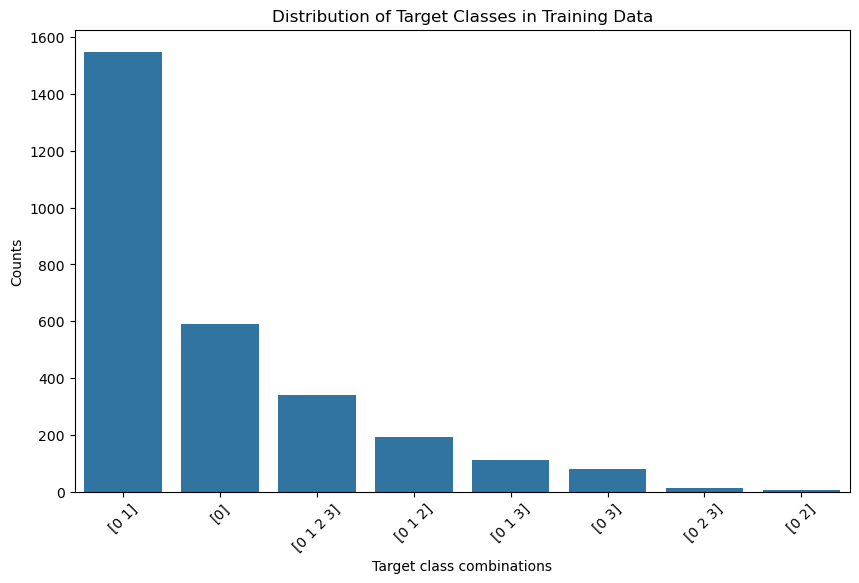

In [118]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the target distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=target_vc.index, y=target_vc.values)
plt.xlabel('Target class combinations')
plt.ylabel('Counts')
plt.title('Distribution of Target Classes in Training Data')
plt.xticks(rotation=45)
plt.show()

In [119]:
df_without_background = target_dist_train[target_dist_train['targets'] != '[0]']

In [130]:
df_bg_only = target_dist_train[target_dist_train['targets'] == '[0]']

In [131]:
df_bg_only['disaster'].value_counts()

disaster
earthquake    319
volcano       249
explosion      13
flood          11
Name: count, dtype: int64

In [132]:
df_bg_only['place'].value_counts()

place
morocco     310
la_palma    233
congo        16
bata         13
libya        11
turkey        7
haiti         2
Name: count, dtype: int64

In [95]:
df_without_background.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2298 entries, 0 to 2889
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   tile              2298 non-null   object 
 1   targets           2298 non-null   object 
 2   background        2298 non-null   int64  
 3   building          2298 non-null   int64  
 4   intact            2298 non-null   int64  
 5   damaged           2298 non-null   int64  
 6   destroyed         2298 non-null   int64  
 7   background_ratio  2298 non-null   float64
 8   building_ratio    2298 non-null   float64
 9   intact_ratio      2298 non-null   float64
 10  damaged_ratio     2298 non-null   float64
 11  destroyed_ratio   2298 non-null   float64
dtypes: float64(5), int64(5), object(2)
memory usage: 233.4+ KB


In [101]:
sums_pixels = df_without_background[['background', 'intact', 'damaged', 'destroyed']].sum(axis=0)

In [103]:
allpx = sums_pixels.sum(axis=0)

In [106]:
sums_pixels/allpx

background    0.809461
intact        0.168476
damaged       0.008738
destroyed     0.013325
dtype: float64

In [140]:
df_without_background.describe()

,background,building,intact,damaged,destroyed,background_ratio,building_ratio,intact_ratio,damaged_ratio,destroyed_ratio
count,2.298000e+03,2298.000000,2298.000000,2298.000000,2298.000000,2298.000000,2298.000000,2298.000000,2298.000000,2298.000000
mean,8.487811e+05,199794.904265,176659.954308,9162.407746,13972.542211,0.809461,0.190539,0.168476,0.008738,0.013325
std,1.885182e+05,188518.194148,181868.069629,39091.433960,52074.642047,0.179785,0.179785,0.173443,0.037280,0.049662
min,1.188200e+05,52.000000,0.000000,0.000000,0.000000,0.113316,0.000050,0.000000,0.000000,0.000000
25%,7.136215e+05,32183.500000,18960.000000,0.000000,0.000000,0.680562,0.030693,0.018082,0.000000,0.000000
50%,9.077385e+05,140837.500000,112345.500000,0.000000,0.000000,0.865687,0.134313,0.107141,0.000000,0.000000
75%,1.016392e+06,334954.500000,297705.750000,0.000000,0.000000,0.969307,0.319438,0.283914,0.000000,0.000000
max,1.048524e+06,929756.000000,929756.000000,604512.000000,718680.000000,0.999950,0.886684,0.886684,0.576508,0.685387


In [141]:
df_without_background

,tile,targets,background,building,intact,damaged,destroyed,background_ratio,building_ratio,intact_ratio,damaged_ratio,destroyed_ratio,place,disaster
0,la_palma-volcano_00000077_building_damage.tif,[0 1],1026055,22521,22521,0,0,0.978522,0.021478,0.021478,0.000000,0.000000,la_palma,volcano
1,congo-volcano_00000053_building_damage.tif,[0 1],1031324,17252,17252,0,0,0.983547,0.016453,0.016453,0.000000,0.000000,congo,volcano
2,turkey-earthquake_00000537_building_damage.tif,[0 1],719701,328875,328875,0,0,0.686360,0.313640,0.313640,0.000000,0.000000,turkey,earthquake
4,turkey-earthquake_00000273_building_damage.tif,[0 1 2 3],611461,437115,388743,7898,40474,0.583135,0.416865,0.370734,0.007532,0.038599,turkey,earthquake
5,bata-explosion_00000016_building_damage.tif,[0 1],902043,146533,146533,0,0,0.860255,0.139745,0.139745,0.000000,0.000000,bata,explosion
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2885,turkey-earthquake_00000293_building_damage.tif,[0 1],614850,433726,433726,0,0,0.586367,0.413633,0.413633,0.000000,0.000000,turkey,earthquake
2886,la_palma-volcano_00000115_building_damage.tif,[0 1],974490,74086,74086,0,0,0.929346,0.070654,0.070654,0.000000,0.000000,la_palma,volcano
2887,la_palma-volcano_00000071_building_damage.tif,[0 1],1047461,1115,1115,0,0,0.998937,0.001063,0.001063,0.000000,0.000000,la_palma,volcano
2888,la_palma-volcano_00000551_building_damage.tif,[0 3],1026300,22276,0,0,22276,0.978756,0.021244,0.000000,0.000000,0.021244,la_palma,volcano


In [150]:
df_without_background[df_without_background['destroyed_ratio'] > 0.3]

,tile,targets,background,building,intact,damaged,destroyed,background_ratio,building_ratio,intact_ratio,damaged_ratio,destroyed_ratio,place,disaster
6,la_palma-volcano_00000419_building_damage.tif,[0 3],670467,378109,0,0,378109,0.639407,0.360593,0.000000,0.000000,0.360593,la_palma,volcano
434,la_palma-volcano_00000390_building_damage.tif,[0 1 3],607598,440978,44188,0,396790,0.579451,0.420549,0.042141,0.000000,0.378408,la_palma,volcano
683,la_palma-volcano_00000484_building_damage.tif,[0 3],699492,349084,0,0,349084,0.667088,0.332912,0.000000,0.000000,0.332912,la_palma,volcano
722,la_palma-volcano_00000481_building_damage.tif,[0 1 3],709033,339543,10499,0,329044,0.676187,0.323813,0.010013,0.000000,0.313801,la_palma,volcano
1231,la_palma-volcano_00000595_building_damage.tif,[0 3],585603,462973,0,0,462973,0.558475,0.441525,0.000000,0.000000,0.441525,la_palma,volcano
1447,la_palma-volcano_00000450_building_damage.tif,[0 3],659060,389516,0,0,389516,0.628529,0.371471,0.000000,0.000000,0.371471,la_palma,volcano
1528,la_palma-volcano_00000570_building_damage.tif,[0 3],728537,320039,0,0,320039,0.694787,0.305213,0.000000,0.000000,0.305213,la_palma,volcano
1591,la_palma-volcano_00000617_building_damage.tif,[0 1 2 3],606819,441757,20846,8733,412178,0.578708,0.421292,0.019880,0.008328,0.393084,la_palma,volcano
1614,la_palma-volcano_00000512_building_damage.tif,[0 3],679119,369457,0,0,369457,0.647658,0.352342,0.000000,0.000000,0.352342,la_palma,volcano
1619,la_palma-volcano_00000567_building_damage.tif,[0 3],660033,388543,0,0,388543,0.629457,0.370543,0.000000,0.000000,0.370543,la_palma,volcano


In [176]:
len(target_dist_train[(target_dist_train['intact_building_ratio'] > 0.5) & (target_dist_train['disaster'] == 'earthquake')])

1229

In [178]:
target_dist_train[target_dist_train['disaster'] == 'earthquake'].describe()

,background,building,intact,damaged,destroyed,background_ratio,building_ratio,intact_ratio,damaged_ratio,destroyed_ratio,intact_building_ratio,damaged_building_ratio,destroyed_building_ratio
count,1.572000e+03,1572.000000,1572.000000,1572.000000,1572.000000,1572.000000,1572.000000,1572.000000,1572.000000,1572.000000,1253.000000,1253.000000,1253.000000
mean,8.519208e+05,196655.208015,183634.155216,7624.057888,5396.994911,0.812455,0.187545,0.175127,0.007271,0.005147,0.952579,0.029101,0.018320
std,2.003540e+05,200353.976086,189978.507724,25949.157950,20070.126599,0.191072,0.191072,0.181178,0.024747,0.019140,0.115939,0.076444,0.057404
min,1.848720e+05,0.000000,0.000000,0.000000,0.000000,0.176308,0.000000,0.000000,0.000000,0.000000,0.146923,0.000000,0.000000
25%,6.957750e+05,2649.000000,2619.000000,0.000000,0.000000,0.663543,0.002526,0.002498,0.000000,0.000000,0.966510,0.000000,0.000000
50%,9.143285e+05,134247.500000,125430.500000,0.000000,0.000000,0.871972,0.128028,0.119620,0.000000,0.000000,1.000000,0.000000,0.000000
75%,1.045927e+06,352801.000000,324473.750000,99.500000,0.000000,0.997474,0.336457,0.309442,0.000095,0.000000,1.000000,0.015167,0.003054
max,1.048576e+06,863704.000000,863704.000000,337683.000000,235731.000000,1.000000,0.823692,0.823692,0.322040,0.224811,1.000000,0.796845,0.644006
